# BEiT
### Initialization of file

In [1]:
%pip install -r requirements.txt 

Note: you may need to restart the kernel to use updated packages.


## Image Preprocessing

For the purposes of our project we will be using two datasets: [Automatic License Plate Detection Dataset](https://github.com/Asikpalysik/Automatic-License-Plate-Detection/tree/main/images) and [Vehicle Registration Plates Dataset](https://huggingface.co/datasets/keremberke/license-plate-object-detection). Both datasets contain images of different shapes and sizes. Normally this wouldn't be a problem but BEiT requires that all images in the dataset be of the same size. `imgaug` was used instead to rescale the images instead of the `BeitImageProcessor` so that the bounding boxes could be correctly scaled.

To save us the hassle of using the Kaggle CLI to access the Automatic License Plate Detection Dataset, I manually downloaded the dataset. The images and their xml annotations were originally in the same folder, but to make data processing easier I separated the data into two folders: images and xml.

In [1]:
import os
import json
import xml.etree.ElementTree as xt
import shutil
import numpy.random as rng

def create_metadata_json(set: str, path: str, files: list[str]):
    with open(path + f"/{set}/metadata.jsonl", "w") as metadata_json:
        for img_file in files:
            file_name, _ = img_file.split(".")
            tree = xt.parse(cwd + "/xml/" + file_name + ".xml")
            bndbox = tree.find("object/bndbox")
            x0 = int(bndbox.findtext("xmin"))
            y0 = int(bndbox.findtext("ymin"))
            x1 = int(bndbox.findtext("xmax"))
            y1 = int(bndbox.findtext("ymax"))

            objs = dict(bbox=[[x0, y0, x1 - x0, y1 - y0]], categories=[0])
            metadata_row = json.dumps(dict(file_name=img_file, objects=objs))
            metadata_json.write(f"{metadata_row}\n")

cwd = os.getcwd()
ds_path = cwd + "/small_dataset"

# Creating a separate directory to store the training and testing sets
if os.path.exists(ds_path):
    shutil.rmtree(ds_path)

os.makedirs(ds_path + "/train")
os.makedirs(ds_path + "/test")

# Randomly placing images into these sets
img_files = os.listdir(cwd + "/images")
ps = rng.uniform(0, 1, len(img_files))
for file, p in zip(img_files, ps):
    if p > 0.25:
        shutil.copy(cwd + "/images/" + file, ds_path + "/train/" + file)
    else:
        shutil.copy(cwd + "/images/" + file, ds_path + "/test/" + file)

# Creating a metadata file for HuggingFace to create the Dataset variable from
dataset = dict(train=os.listdir(ds_path + "/train"), test=os.listdir(ds_path + "/test"))
for k in dataset:
    create_metadata_json(k, ds_path, dataset[k])

Fortunately, the Vehicle Registration Plates Dataset could be accessed via the HuggingFace Python library.

In [5]:
from datasets import load_dataset
from imgaug.augmentables.bbs import BoundingBoxesOnImage, BoundingBox
import imgaug as ia
import numpy as np

IMG_RES = 640

# Split datasets
small_ds = load_dataset("imagefolder", data_dir=cwd+"/small_dataset")
small_ds_train_imgs = [np.array(file["image"]) for file in small_ds["train"]]
small_ds_test_imgs = [np.array(file["image"]) for file in small_ds["test"]]

large_ds = load_dataset("keremberke/license-plate-object-detection", name="full")
large_ds_train_imgs = [np.array(file["image"]) for file in large_ds["train"]]
large_ds_valid_imgs = [np.array(file["image"]) for file in large_ds["validation"]]
large_ds_test_imgs = [np.array(file["image"]) for file in large_ds["test"]]

# Generate bounding boxes for each dataset split
small_ds_train_bbs = [BoundingBoxesOnImage([BoundingBox(
    x1=file["objects"]["bbox"][0][0],
    y1=file["objects"]["bbox"][0][1],
    x2=file["objects"]["bbox"][0][0] + file["objects"]["bbox"][0][2],
    y2=file["objects"]["bbox"][0][1] + file["objects"]["bbox"][0][3],   
)], shape=img.shape) for file, img in zip(small_ds["train"], small_ds_train_imgs)]
small_ds_test_bbs = [BoundingBoxesOnImage([BoundingBox(
    x1=file["objects"]["bbox"][0][0],
    y1=file["objects"]["bbox"][0][1],
    x2=file["objects"]["bbox"][0][0] + file["objects"]["bbox"][0][2],
    y2=file["objects"]["bbox"][0][1] + file["objects"]["bbox"][0][3],   
)], shape=img.shape) for file, img in zip(small_ds["test"], small_ds_test_imgs)]

large_ds_train_bbs = [BoundingBoxesOnImage([BoundingBox(
    x1=file["objects"]["bbox"][0][0],
    y1=file["objects"]["bbox"][0][1],
    x2=file["objects"]["bbox"][0][0] + file["objects"]["bbox"][0][2],
    y2=file["objects"]["bbox"][0][1] + file["objects"]["bbox"][0][3],
)], shape=img.shape) for file, img in zip(large_ds["train"], large_ds_train_imgs)]
large_ds_valid_bbs = [BoundingBoxesOnImage([BoundingBox(
    x1=file["objects"]["bbox"][0][0],
    y1=file["objects"]["bbox"][0][1],
    x2=file["objects"]["bbox"][0][0] + file["objects"]["bbox"][0][2],
    y2=file["objects"]["bbox"][0][1] + file["objects"]["bbox"][0][3],
)], shape=img.shape) for file, img in zip(large_ds["validation"], large_ds_valid_imgs)]
large_ds_test_bbs = [BoundingBoxesOnImage([BoundingBox(
    x1=file["objects"]["bbox"][0][0],
    y1=file["objects"]["bbox"][0][1],
    x2=file["objects"]["bbox"][0][0] + file["objects"]["bbox"][0][2],
    y2=file["objects"]["bbox"][0][1] + file["objects"]["bbox"][0][3],
)], shape=img.shape) for file, img in zip(large_ds["test"], large_ds_test_imgs)]

# Rescale images and bounding boxes
small_ds_train_imgs_rescaled = ia.imresize_many_images(small_ds_train_imgs, (IMG_RES, IMG_RES))
small_ds_train_bbs_rescaled = [bb.on(img) for bb, img in zip(small_ds_train_bbs, small_ds_train_imgs_rescaled)]
small_ds_test_imgs_rescaled = ia.imresize_many_images(small_ds_test_imgs, (IMG_RES, IMG_RES))
small_ds_test_bbs_rescaled = [bb.on(img) for bb, img in zip(small_ds_test_bbs, small_ds_test_imgs_rescaled)]

large_ds_train_imgs_rescaled = ia.imresize_many_images(large_ds_train_imgs, (IMG_RES, IMG_RES))
large_ds_train_bbs_rescaled = [bb.on(img) for bb, img in zip(large_ds_train_bbs, large_ds_train_imgs_rescaled)]
large_ds_valid_imgs_rescaled = ia.imresize_many_images(large_ds_valid_imgs, (IMG_RES, IMG_RES))
large_ds_valid_bbs_rescaled = [bb.on(img) for bb, img in zip(large_ds_valid_bbs, large_ds_valid_imgs_rescaled)]
large_ds_test_imgs_rescaled = ia.imresize_many_images(large_ds_test_imgs, (IMG_RES, IMG_RES))
large_ds_test_bbs_rescaled = [bb.on(img) for bb, img in zip(large_ds_test_bbs, large_ds_test_imgs_rescaled)]

Here is a snippet of images that will be inputted into the preprocessing API.

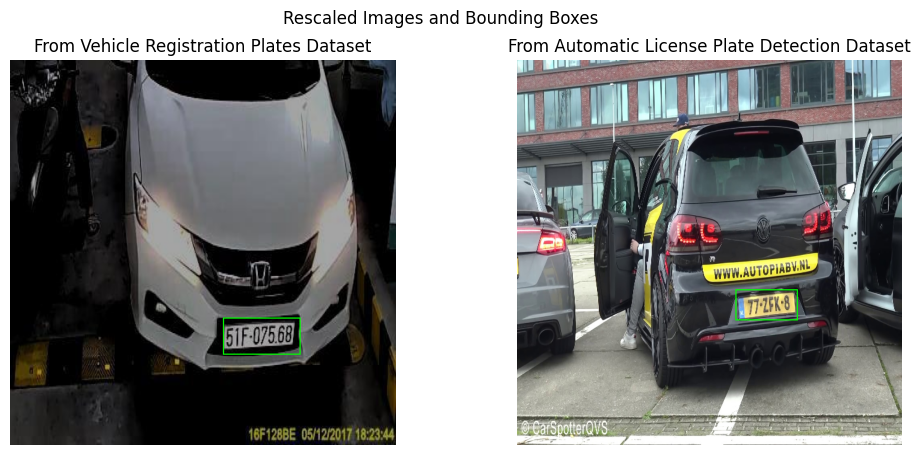

In [13]:
import matplotlib.pyplot as plt

idx = 0
fig, (ax_lg, ax_sm) = plt.subplots(ncols=2, figsize=(12, 5))
ax_lg.imshow(large_ds_train_bbs_rescaled[idx].draw_on_image(large_ds_train_imgs_rescaled[idx], size=2))
ax_sm.imshow(small_ds_train_bbs_rescaled[idx].draw_on_image(small_ds_train_imgs_rescaled[idx], size=2))
ax_lg.axis("off")
ax_sm.axis("off")
ax_lg.set_title("From Vehicle Registration Plates Dataset")
ax_sm.set_title("From Automatic License Plate Detection Dataset")
fig.suptitle("Rescaled Images and Bounding Boxes")
plt.show()

After that initial preprocessing, we run the datasets through the dedicated image processor for BEiT.

In [14]:
from transformers import BeitImageProcessor

img_processor = BeitImageProcessor.from_pretrained("microsoft/beit-large-finetuned-ade-640-640")
large_ds_train_processed_imgs = img_processor(large_ds_train_imgs_rescaled, return_tensors="pt")
small_ds_train_processed_imgs = img_processor(small_ds_train_imgs_rescaled, return_tensors="pt")

: 

## The Model
### Creation of Object Detection Network
The architecture of BEiT does not support object detection so this functionality must be built on top the model. I believe this is possible by using the BEiT's existing support for semantic segmentation. This new model will take the output of BEiT's semantic segmentation model and learn to apply bounding boxes to the image correctly.

In [3]:
import torch
from torch import nn, optim

class BoundingBoxRegression(nn.Module):
    def __init__(self, 
                 input_size, 
                 batch_size=1,
                 max_iter=10_000,
                 learning_rate=0.0001,
                 device="cpu",
                 *args, 
                 **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.device = device
        self.layers = nn.Sequential(
            nn.Linear(input_size, 4, device=self.device),
            nn.Sigmoid()
        )
        self.optimizer = optim.SGD(
            self.parameters(),
            lr=learning_rate
        )

    def forward(self, X):
        return self.layers.forward(X)


    def fit(self, X, y):
        if X is None or y is None:
            raise Exception("Neither the training data nor labels can be missing when fitting the model")

        X = torch.as_tensor(X, dtype=torch.get_default_dtype, device=self.device)
        loss_fn = nn.MSELoss()

        for i in range(self.max_iter):
            self.optimizer.zero_grad()

            batch_idxs = torch.as_tensor(
                np.random.choice(X.shape[0], size=self.batch_size, replace=False)
            )
            yhat = self(X[batch_idxs])
            loss = loss_fn(yhat, y[batch_idxs])

            loss.backward()
            self.optimizer.step()

            if i % 1_000 == 0:
                print(f"Iteration {i}: loss = {loss:.2f}")

    def predict(self, X):
        X = torch.as_tensor(X, dtype=torch.get_default_dtype, device=self.device)
        with torch.no_grad():
            return self(X).cpu().numpy()


### Training the Model
On the [Hugginface Hub for BEiT](https://huggingface.co/models?search=microsoft/beit) there were various pre-trained models. I selected the `beit-large-finetuned-ade-640-640` because this variant of BEiT was finetuned for semantic segmentation.

In [ ]:
from transformers import BeitForSemanticSegmentation

beit_model_on_large_ds = BeitForSemanticSegmentation.from_pretrained("microsoft/beit-large-finetuned-ade-640-640")
beit_model_on_small_ds = BeitForSemanticSegmentation.from_pretrained("microsoft/beit-large-finetuned-ade-640-640")
train_output_on_large_ds = beit_model_on_large_ds(**large_ds_train_processed_imgs)
train_output_on_small_ds = beit_model_on_small_ds(**small_ds_train_processed_imgs)

bbr_model_on_large_ds = BoundingBoxRegression(int(0.5 * len(large_ds["train"])))
bbr_model_on_small_ds = BoundingBoxRegression(int(0.5 * len(small_ds["train"])))

bbr_model_on_large_ds.fit(train_output_on_large_ds, large_ds_train_bbs_rescaled)
bbr_model_on_small_ds.fit(train_output_on_small_ds, small_ds_train_bbs_rescaled)

yhat_lg_ds = bbr_model_on_large_ds.predict(train_output_on_large_ds)
yhat_sm_ds = bbr_model_on_small_ds.predict(train_output_on_small_ds)

print(f"Dataset: Vehicle Registration Plates, Training Error: {np.mean(yhat_lg_ds != large_ds_train_bbs_rescaled)}")
print(f"Dataset: Automatic License Plate Detection, Training Error: {np.mean(yhat_sm_ds != small_ds_train_bbs_rescaled)}")

### Testing the Model

In [ ]:
test_output_on_large_ds = beit_model_on_large_ds(**large_ds_train_processed_imgs)
test_output_on_small_ds = beit_model_on_small_ds(**small_ds_train_processed_imgs)

yhat_lg_ds = bbr_model_on_large_ds.predict(test_output_on_large_ds)
yhat_sm_ds = bbr_model_on_small_ds.predict(test_output_on_small_ds)

print(f"Dataset: Vehicle Registration Plates, Test Error: {np.mean(yhat_lg_ds != large_ds_test_bbs_rescaled)}")
print(f"Dataset: Automatic License Plate Detection, Test Error: {np.mean(yhat_sm_ds != small_ds_test_bbs_rescaled)}")